# Predictive Maintenance Dataset Overview

## Dataset Description
This synthetic dataset mimics real-world predictive maintenance scenarios, as actual datasets are hard to obtain and publish. It contains **10,000 data points** with **14 features**, reflecting industrial predictive maintenance challenges.

## Features
| **Feature**               | **Description**                                                                                     |
|---------------------------|-----------------------------------------------------------------------------------------------------|
| **UID**                   | Unique identifier (1 to 10,000).                                                                   |
| **Product ID**            | Product quality variant (L: low, 50%; M: medium, 30%; H: high, 20%) with a variant-specific serial number. |
| **Air Temperature [K]**   | Generated via random walk, normalized to a standard deviation of 2 K around 300 K.                |
| **Process Temperature [K]** | Generated via random walk, normalized to a standard deviation of 1 K, added to air temperature + 10 K. |
| **Rotational Speed [rpm]**| Calculated from 2860 W power, with normally distributed noise.                                     |
| **Torque [Nm]**           | Normally distributed around 40 Nm (σ = 10 Nm), no negative values.                                |
| **Tool Wear [min]**       | Adds 5/3/2 minutes for H/M/L variants; indicates tool usage time.                                 |
| **Machine Failure**       | Label (1 or 0) indicating if the machine failed due to any failure mode.                           |

## Failure Modes
The **Machine Failure** label is 1 if any of the following independent failure modes occur:

| **Failure Mode**          | **Condition**                                                                                     | **Occurrences** |
|---------------------------|---------------------------------------------------------------------------------------------------|-----------------|
| **Tool Wear Failure (TWF)** | Tool fails/replaced at 200–240 mins (random); replaced 69 times, fails 51 times.                 | 120             |
| **Heat Dissipation Failure (HDF)** | Fails if air-process temp difference < 8.6 K and rotational speed < 1380 rpm.                  | 115             |
| **Power Failure (PWF)**   | Fails if power (torque × rotational speed in rad/s) < 3500 W or > 9000 W.                        | 95              |
| **Overstrain Failure (OSF)** | Fails if tool wear × torque exceeds 11,000 (L), 12,000 (M), or 13,000 (H) minNm.                | 98              |
| **Random Failures (RNF)** | 0.1% chance of failure regardless of parameters.                                                 | 5               |

### Notes
- A machine failure occurs if **at least one** failure mode is true, setting the `Machine Failure` label to 1.
- The specific failure mode causing the failure is **not** specified in the label, making it a challenge for machine learning models to identify the root cause.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('data.csv')
df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [4]:
df.describe()

UDI  Air temperature [K]  Process temperature [K]  \
count  10000.00000         10000.000000             10000.000000   
mean    5000.50000           300.004930               310.005560   
std     2886.89568             2.000259                 1.483734   
min        1.00000           295.300000               305.700000   
25%     2500.75000           298.300000               308.800000   
50%     5000.50000           300.100000               310.100000   
75%     7500.25000           301.500000               311.100000   
max    10000.00000           304.500000               313.800000   

       Rotational speed [rpm]   Torque [Nm]  Tool wear [min]  Machine failure  \
count            10000.000000  10000.000000     10000.000000     10000.000000   
mean              1538.776100     39.986910       107.951000         0.033900   
std                179.284096      9.968934        63.654147         0.180981   
min               1168.000000      3.800000         0.000000         0.000000   
25%               1423.000000     33.200000        53.000000         0.000000   
50%               1503.000000     40.100000       108.000000         0.000000   
75%               1612.000000     46.800000       162.000000         0.000000   
max               2886.000000     76.600000       253.000000         1.000000   

                TWF           HDF           PWF           OSF          RNF  
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.00000  
mean       0.004600      0.011500      0.009500      0.009800      0.00190  
std        0.067671      0.106625      0.097009      0.098514      0.04355  
min        0.000000      0.000000      0.000000      0.000000      0.00000  
25%        0.000000      0.000000      0.000000      0.000000      0.00000  
50%        0.000000      0.000000      0.000000      0.000000      0.00000  
75%        0.000000      0.000000      0.000000      0.000000      0.00000  
max        1.000000      1.000000      1.000000      1.000000      1.00000

In [ ]:
def get_failure_type(row):
    if row['TWF'] == 1:
        return 'TWF'
    elif row['HDF'] == 1:
        return 'HDF'
    elif row['PWF'] == 1:
        return 'PWF'
    elif row['OSF'] == 1:
        return 'OSF'
    elif row['RNF'] == 1:
        return 'RNF'
    else:
        return np.nan

df['failure_type'] = df.apply(get_failure_type, axis=1)
df['failure_type'].replace(np.nan, 'no failure', inplace=True)
df.drop(['TWF', 'HDF', 'PWF', 'OSF', 'RNF'], axis=1, inplace=True)
df.head()





C:\Users\manis\AppData\Local\Temp\ipykernel_11812\4120790316.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['failure_type'].replace(np.nan, 'no failure', inplace=True)


UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  \
0                    1551         42.8                0                0   
1                    1408         46.3                3                0   
2                    1498         49.4                5                0   
3                    1433         39.5                7                0   
4                    1408         40.0                9                0   

  failure_type  
0   no failure  
1   no failure  
2   no failure  
3   no failure  
4   no failure

# Manish's Plan to Stop Machine Breakdowns

- **Here’s the Deal**: It’s 6:00 PM IST on Friday, June 13, 2025, and I’m Manish, the maintenance supervisor at a busy factory in India. Our machines keep breaking down, and it’s slowing us down big time. I’ve got a dataset of 10,000 machine runs with info on temperatures, speed, torque, tool wear, and failures. My job? Find the patterns to stop these breakdowns. Let’s dive in!

---

## My Quick Checks: Finding the Problem

- **Check 1: How Often Do Machines Break?**  
  First, I need the basics. What’s the distribution of the `Machine failure` label in the dataset? How many machines failed, and how many didn’t? This will show if breakdowns are a rare issue or a big headache.

- **Check 2: What Products Are We Making?**  
 What is the distribution of the 'productID' variable in the dataset? How many instances are of low, medium, and high quality variants?

- **Check 3: How Are Machines Running? Any Weird Numbers?**  
  Let’s look at machine conditions. What’s the range of values for `Air temperature`, `Process temperature`, `Rotational speed`, `Torque`, and `Tool wear`? Are there any outliers in the dataset ?

- **Check 4: What Conditions Cause Failures?**  
  I need to spot red flags. Is there any correlation between the continuous variables and the `Machine failure` label? For example, does higher tool wear lead to more machine failures, or is something else the culprit?

- **Check 5: Does Product Type Change How Machines Run?**  
  Do product types affect machine conditions? Is there any correlation between the `Product ID` (`Type`) and the continuous variables? For example, is the `Rotational speed` higher for high-quality products than low-quality ones, or do some products stress the machines more?

- **Check 6: Are There Sneaky Patterns to Catch?**  
  Let’s look deeper. Are there any interactions or non-linear relationships between the variables that matter for predictive maintenance? For example, does the torque shoot up fast with rotational speed, or are there other patterns to help us predict breakdowns?

---


## Let's Start one by one : -

- **Check 1: How Often Do Machines Break?**  
  First, I need the basics. What’s the distribution of the `Machine failure` label in the dataset? How many machines failed, and how many didn’t? This will show if breakdowns are a rare issue or a big headache

In [14]:
import plotly.express as px

category_counts=df['failure_type'].value_counts()
total_samples=len(df)
category_percentages=category_counts/total_samples*100
categories=list(category_percentages.index)

category_percentages,categories

(failure_type
 no failure    96.52
 HDF            1.15
 PWF            0.91
 OSF            0.78
 TWF            0.46
 RNF            0.18
 Name: count, dtype: float64,
 ['no failure', 'HDF', 'PWF', 'OSF', 'TWF', 'RNF'])

In [15]:
percentage_labels = list(category_percentages)
# Format the percentage labels
percentage_labels = [f'{num:.2f}%' for num in percentage_labels]

fig = px.histogram(df, x='failure_type', category_orders={'failure_type': categories})
fig.update_traces(text=percentage_labels, textposition='auto')

fig.show()

The success rate of the machine is 96.52% and the highest type of failure is HDF(Heat Dissipation Failure) with 1.15% failure rate.

- **Check 2: What Products Are We Making?**  
What is the distribution of the 'productID' variable in the dataset? How many instances are of low, medium, and high quality variants?

In [22]:
df['Type'].value_counts()/len(df)*100

Type
L    60.00
M    29.97
H    10.03
Name: count, dtype: float64

<Axes: xlabel='Type', ylabel='count'>

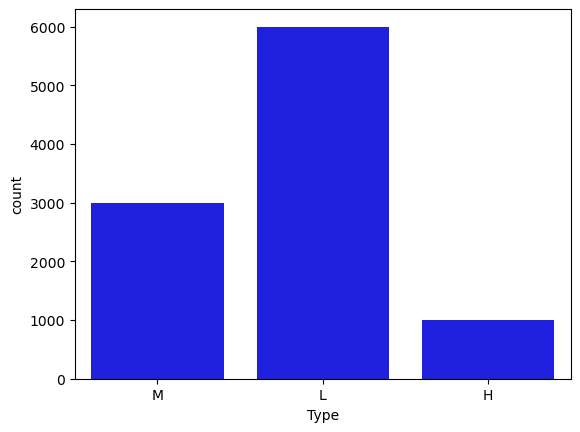

In [21]:
sns.countplot( x='Type',data=df,color='blue')

low quality varient makes up majority of the dataset with 60% of the data, followed by medium quality varient with 30% and high quality varient with 10%.

- **Check 3: How Are Machines Running? Any Weird Numbers?**  
  Let’s look at machine conditions. What’s the range of values for `Air temperature`, `Process temperature`, `Rotational speed`, `Torque`, and `Tool wear`? Are there any outliers in the dataset ?


In [23]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

num_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

fig = make_subplots(rows=5, cols=1, subplot_titles=num_cols, vertical_spacing=0.04)


for i, col in enumerate(num_cols):
    box_plot = go.Box(x=df[col], name=col)
    fig.add_trace(box_plot, row=i+1, col=1)

fig.update_layout(
    title="Distribution of Numerical Features",
    height=1200,
    width=900,
    title_text="Box plots"
)

fig.show()


In [26]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

outlier_cols = ['Torque [Nm]', 'Rotational speed [rpm]']

fig2 = make_subplots(rows=1, cols=2, subplot_titles=outlier_cols, vertical_spacing=0.03)

for i, col in enumerate(outlier_cols):
    box_plot = go.Histogram(x=df[col], name=col)
    fig2.add_trace(box_plot, row=1, col=i+1)

fig2.update_layout(
    title='Distribution of Torque and Rotational speed',
    yaxis_title='Frequency',
    title_text="Histograms",
    width=900
)
fig2.show()

rotational speed may or may not be actual outliers, therefore we'll keep them in the dataset for now. (same for torque )

 **Check 4: What Conditions Cause Failures?**  
  I need to spot red flags. Is there any correlation between the continuous variables and the `Machine failure` label? For example, does higher tool wear lead to more machine failures, or is something else the culprit?

In [27]:
import plotly.express as px
corr_matrix = df[['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure']].corr()

fig = px.imshow(corr_matrix, zmin=-1, zmax=1, text_auto=True)

fig.update_layout(
    title='Correlation Matrix',
    height=600,
    width=800
)

fig.show()

Let's test it using statistical tests : -  

Null Hypothesis: There is no signifcant relationship between the different columns and Machine Failure. 

Alternate Hypothesis: There is a significant relationship between the different columns and the machine failure label.

In [28]:
from scipy.stats import ttest_ind

test_cols = ['Air temperature [K]','Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]','Tool wear [min]']
values = []

for col in test_cols:
    failed = df[df['Machine failure'] == 1][col]
    non_failed = df[df['Machine failure'] == 0][col]

    t, p = ttest_ind(failed, non_failed)
    values.append([t, p])

values = pd.DataFrame(values, columns=['test-statistic', 'p-value'], index=test_cols)
alpha = 0.05
values['Hypothesis'] = values['p-value'].apply(lambda p: 'Reject null hypothesis' if p < alpha else 'Accept null hypothesis')
values

test-statistic       p-value              Hypothesis
Air temperature [K]            8.283018  1.354800e-16  Reject null hypothesis
Process temperature [K]        3.596562  3.240058e-04  Reject null hypothesis
Rotational speed [rpm]        -4.422634  9.853543e-06  Reject null hypothesis
Torque [Nm]                   19.490196  4.573805e-83  Reject null hypothesis
Tool wear [min]               10.602881  3.976076e-26  Reject null hypothesis

test confirmed that `Air temperature`, `Process temperature`, `Rotational speed`, `Torque`, and  `Tool wear` have a strong link to machine failures

- **Check 5: Does Product Type Change How Machines Run?**  
  Do product types affect machine conditions? Is there any correlation between the `Product ID` (`Type`) and the continuous variables? For example, is the `Rotational speed` higher for high-quality products than low-quality ones, or do some products stress the machines more?


In [29]:
import plotly.express as px
import plotly.graph_objects as go

from plotly.subplots import make_subplots
num_cols = ['Air temperature [K]','Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]','Tool wear [min]']
fig = make_subplots(rows=5, cols=1, subplot_titles=num_cols, vertical_spacing=0.03, horizontal_spacing=0.01)

for i, col in enumerate(num_cols):
    violin_trace = go.Violin(x=df['Type'], y=df[col],name=col,  box_visible=True, meanline_visible=True)
    fig.add_trace(violin_trace, row=i+1, col=1)

fig.update_layout(height=2000, width=800, title_text="Subplots")

fig.show()

low-quality products may stress machines more, and key conditions like tool wear significantly impact failures


- **Check 6: Are There Sneaky Patterns to Catch?**  
  Let’s look deeper. Are there any interactions or non-linear relationships between the variables that matter for predictive maintenance? For example, does the torque shoot up fast with rotational speed, or are there other patterns to help us predict breakdowns?

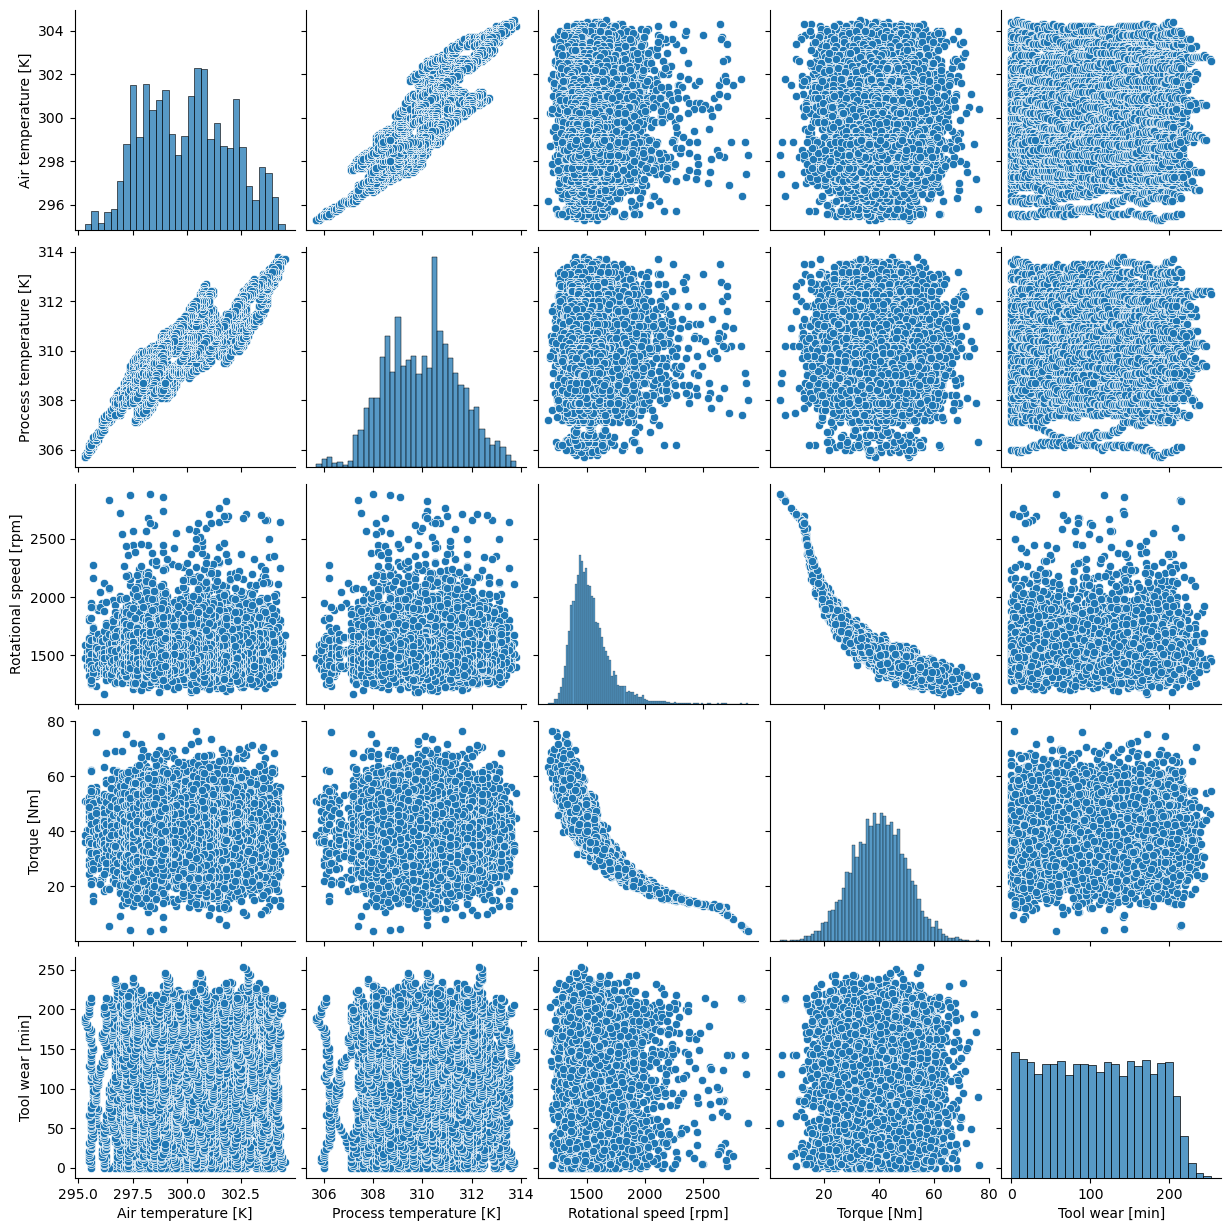

In [34]:
num_cols = df[['Air temperature [K]','Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]','Tool wear [min]']]
sns.pairplot(num_cols)


Among all possible combinations of continuous variables, Rotational Speed vs Torque have a negative correlation and process temperature vs air temperature have a positive correlation.

## Final Conclusion


Manish’s analysis reveals that machine failures occur in 3.48% of cases, with low-quality products linked to higher stress on machines. Key factors like tool wear and torque significantly influence failures. He plans to monitor low-quality products closely and develop a predictive system to minimize breakdowns and enhance factory efficiency.